## Model

In [121]:
import tensorflow as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt

### Utilities

In [89]:
def run_tf(x):
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess: 
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        out = sess.run(x)

        coord.request_stop()
        coord.join(threads)
        
        return out
    

class FLAGS(object):
    pass

FLAGS.batch_size = 10
FLAGS.data_dir = "/home/sankaran/exercise/ML/TF-Exercise/Tutorials/CIFAR/cifar-10-batches-bin"
FLAGS.num_preprocess_threads = 16
FLAGS.num_classes = 10

def distorted_inputs(data_dir, batch_size, distort=True):
    
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i) for i in range(1, 6)]
    
    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames,seed=0)
    
    #Create FixedLenthRecord Reader with fixed bytes to read
    record_bytes = 32*32*3+1 #32*32*3 image with 1 byte for label
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    
    key, value = reader.read(filename_queue)
    
    ##Decode
    decoded = tf.decode_raw(value, tf.uint8)
    label = tf.strided_slice(decoded,[0],[1])
    image = tf.strided_slice(decoded,[1],[record_bytes])
    
    
    label = tf.cast(label,tf.int32)
    label = tf.reshape(label,[1])
    image = tf.reshape(image,[3,32,32])
    image = tf.transpose(image,[1,2,0])
    #image = tf.cast(image,tf.float32) ## DESTROYES IMAGE VIS
    
    ##PRE PROCESS
    if(distort):
        image = tf.random_crop(image, [24, 24, 3])
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image,max_delta=0.4)
        image = tf.image.random_contrast(image,lower=0.5,upper=1.8)
    
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                             min_fraction_of_examples_in_queue)
    
    images, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        num_threads=FLAGS.num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples,
        seed=0)
    
    return [images,label_batch]

### Inputs

(10, 24, 24, 3) (10, 1)


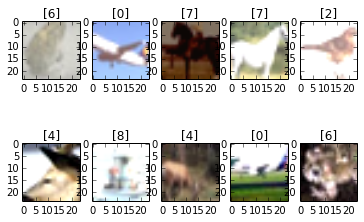

In [8]:
images,labels = distorted_inputs(FLAGS.data_dir,FLAGS.batch_size)
im,l = run_tf([images,labels])
print(im.shape,l.shape)
for j in range(len(im)):
    plt.subplot(2, 5, j+1)
    plt.imshow(im[j, ...])
    plt.title(str(l[j]))
plt.show()

In [13]:
print("Input image : ", images)
print("Input labels : ", labels)

Input image :  Tensor("shuffle_batch_1:0", shape=(10, 24, 24, 3), dtype=float32)
Input labels :  Tensor("shuffle_batch_1:1", shape=(10, 1), dtype=int32)


### Network

In [20]:
def weight_variable(shape,std=0.1,dtype=tf.float32):
  initializer = tf.truncated_normal_initializer(stddev=std, dtype=dtype)
  return tf.get_variable("Weights",shape,initializer=initializer,dtype=dtype)

def bias_variable(shape,const=0.0,dtype=tf.float32):
  initializer = tf.constant_initializer(const,dtype)
  return tf.get_variable("biases",shape,initializer=initializer,dtype=dtype)


** In **

In [77]:
tf.reset_default_graph();

with tf.variable_scope("Input-queue"):
    images,labels = distorted_inputs(FLAGS.data_dir,FLAGS.batch_size)
    input = images
input

<tf.Tensor 'Input-queue/shuffle_batch:0' shape=(10, 24, 24, 3) dtype=float32>

**Conv 1**

NOTE : **name_scope** is ignored by **tf.get_variable**, as it only creates name space for operators. Hence use **variable_scope**

In [78]:
with tf.variable_scope("conv1"):
    W_conv1 = weight_variable([5, 5, 3, 64])
    b_conv1 = bias_variable([64])
    
    conv = tf.nn.conv2d(input,W_conv1,strides=[1,1,1,1],padding="SAME")
    h_conv1 = tf.nn.relu(conv + b_conv1)
h_conv1

<tf.Tensor 'conv1/Relu:0' shape=(10, 24, 24, 64) dtype=float32>

** Pool 1**

In [79]:
with tf.variable_scope("maxpool1"):
    h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
h_pool1

<tf.Tensor 'maxpool1/MaxPool:0' shape=(10, 12, 12, 64) dtype=float32>

** Conv 2**

In [80]:
with tf.variable_scope("conv2"):
    W_conv2 = weight_variable([5, 5, 64, 64])
    b_conv2 = bias_variable([64])
    
    conv = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding="SAME")
    h_conv2 = tf.nn.relu(conv + b_conv2)
h_conv2

<tf.Tensor 'conv2/Relu:0' shape=(10, 12, 12, 64) dtype=float32>

** Pool 2**

In [81]:
with tf.variable_scope("maxpool2"):
    h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
h_pool2

<tf.Tensor 'maxpool2/MaxPool:0' shape=(10, 6, 6, 64) dtype=float32>

**Flatten**

In [82]:
with tf.variable_scope("Flatten"):
    h_pool2_flat = tf.reshape(h_pool2, [FLAGS.batch_size, -1])
h_pool2_flat

<tf.Tensor 'Flatten/Reshape:0' shape=(10, 2304) dtype=float32>

** FC1**

In [83]:
with tf.variable_scope("fc1"):
    W_fc1 = weight_variable([h_pool2_flat.shape[1].value, 384])
    b_fc1 = bias_variable([384])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1

<tf.Tensor 'fc1/Relu:0' shape=(10, 384) dtype=float32>

**FC2**

In [84]:
with tf.variable_scope("fc2"):
    W_fc2 = weight_variable([384, 192])
    b_fc2 = bias_variable([192])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
h_fc2

<tf.Tensor 'fc2/Relu:0' shape=(10, 192) dtype=float32>

** Logit**

In [85]:
with tf.variable_scope("logit"):
    W_fc3 = weight_variable([192, FLAGS.num_classes])
    b_fc3 = bias_variable([FLAGS.num_classes])
    logit = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
logit

<tf.Tensor 'logit/Relu:0' shape=(10, 10) dtype=float32>

### View Graph

In [86]:
tf.summary.FileWriter("log",tf.Session().graph)

<img style="height:600px;" src="net.png" />

### Check 

In [120]:
out = run_tf(logit)
out

array([[ 0.        ,  1.84476   ,  4.125448  ,  2.4655895 ,  0.        ,
         2.2674358 ,  0.0208602 ,  6.213604  ,  1.8814605 ,  0.        ],
       [ 0.        ,  1.1932745 ,  3.6297119 ,  0.75710344,  0.42556894,
         2.7095952 ,  1.2733622 ,  8.402768  ,  3.8125758 ,  0.        ],
       [ 0.        ,  0.        ,  4.247491  ,  1.6186606 ,  0.        ,
         3.32152   ,  0.767244  ,  8.875978  ,  3.4488847 ,  0.        ],
       [ 0.        ,  0.7942474 ,  2.7222605 ,  0.7789866 ,  0.        ,
         1.4450054 ,  0.9488432 ,  4.751667  ,  2.4055111 ,  0.        ],
       [ 0.        ,  2.3574693 ,  5.5602055 ,  1.1164852 ,  0.02570665,
         3.4492981 ,  1.3460425 ,  9.604906  ,  4.568285  ,  0.        ],
       [ 0.        ,  0.47178963,  2.7990727 ,  0.57220984,  0.        ,
         1.2022231 ,  1.144908  ,  5.4256477 ,  2.099354  ,  0.        ],
       [ 0.        ,  0.        ,  3.7268803 ,  0.40264487,  0.21159142,
         0.58817935,  0.90909696,  7.3845015 

### Loss

In [116]:
with tf.variable_scope("cross-entropy"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(labels,[10]), logits=logit)
cross_entropy

<tf.Tensor 'cross-entropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0' shape=(10,) dtype=float32>

In [117]:
avg_cross_entropy = tf.reduce_mean(cross_entropy)
ce_summary = tf.summary.scalar("Cross_entropy_loss",avg_cross_entropy)